## Exploratory Data Analysis
### Time series analysis

**Objetivo**: O objetivo deste notebook é desenvolver a fase de data quality check. Nesta iremos explorar a qualidade e estado dos dados:

* Data profiling;
    * Médias;
    * Outliers;
    * Distribuição;
    * Frequência de observações;
* Forecastability (Análise de autocorrelação);
* Sazonalidade e tendência;
* Estacionaridade;

**Conclusões**:

* Outliers: Temos outliers baixos, que remetem aos primeiros 3 meses dos dados, onde os valores estão todos abaixo de R$ 90, enquanto todo o resto da série acima deste valor.
* Distribuição:
    * Distribuição original: Bimodal, considerando os outliers citados anteiormente.
    * Distribuição sem outliers: Não passou nos testes de normalidade, porém é aproximada;
* Sazonalidade e tendência: No período observado, a série mostrou possuir leve sazonalidade anual e quarterly. Ainda um pouco mais fraca mensal, e nenhuma sazonalidade semanal.
* Análise de autocorrelação: Forte autocorrelação partial com lag 1 apenas, todos os outros insignificativos.
* Estacionariedade: Estacionária com 1 diferenciação.

**Features para modelagem**:
* day_of_month
* quarter
* month

Também testar:
* lag 1
* média móvel 7 dias

### 1.0 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #Autocorrelação (MA), Autocorrelatcao parcial (AR)ve
from pmdarima.arima.utils import ndiffs 

from scipy.stats import shapiro, normaltest, kstest

### 2.0 Data loading

In [2]:
stock_df = pd.read_csv("../data/raw/raw_stock_prices.csv")
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].apply(lambda x: x.date())
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df.rename(columns={"Close": "preco", "Date": "data"})

### 3.0 Data profilling


In [3]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    720 non-null    datetime64[ns]
 1   preco   720 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.4 KB


In [4]:
stock_df.head()

,data,preco
0,2020-03-02,102.989998
1,2020-03-03,101.750000
2,2020-03-04,103.099998
3,2020-03-05,98.790001
4,2020-03-06,94.400002


In [5]:
#timeseries_report = ProfileReport(stock_df.set_index("Date"), ts_mode=False, title="EDA de Fundo de Índice BOVA11")
#timeseries_report.to_file("../reports/BOVA11_report.html")

#### 3.1 Distribuição

In [6]:
stock_df.describe()

,preco
count,720.000000
mean,104.056823
std,11.752078
min,61.139999
25%,98.247499
50%,106.040001
75%,112.080002
max,125.750000


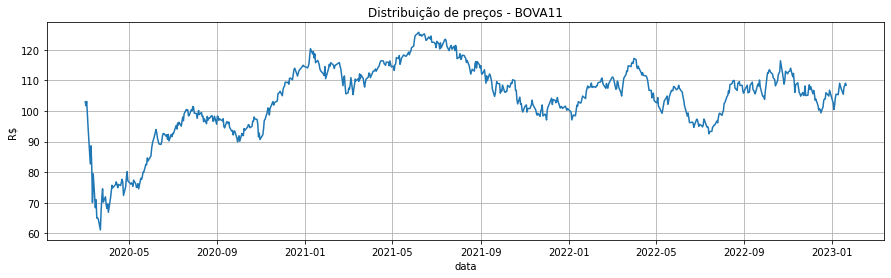

In [7]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.lineplot(
    data=stock_df,
    x="data",
    y="preco",
    ax=axs,
)

axs.set_title("Distribuição de preços - BOVA11")
axs.set_ylabel("R$")

plt.grid()
plt.show()


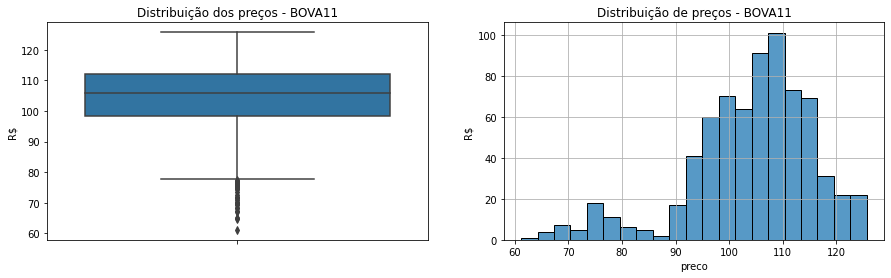

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(
    data=stock_df,
    y="preco",
    ax=axs[0],
)
axs[0].set_title("Distribuição dos preços - BOVA11")
axs[0].set_ylabel("R$")

sns.histplot(
    data=stock_df,
    x="preco",
    ax=axs[1],
)

axs[1].set_title("Distribuição de preços - BOVA11")
axs[1].set_ylabel("R$")

plt.grid()
plt.show()


In [9]:
# Teste na distribuição original
print("Shapiro Test")
statistics, p_value = shapiro(stock_df['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("K-S Test")
statistics, p_value = kstest(stock_df['preco'], 'norm')
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("D’Agostino’s K-squared test")
statistics, p_value = normaltest(stock_df['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

Shapiro Test
Statistics: 0.9387546181678772
 P-valor: 1.2469038344143567e-16
K-S Test
Statistics: 1.0
 P-valor: 0.0
D’Agostino’s K-squared test
Statistics: 105.51793559788781
 P-valor: 1.2220005855455668e-23


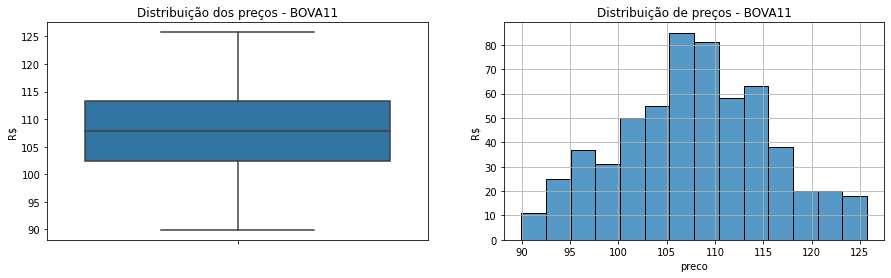

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(
    data=stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')],
    y="preco",
    ax=axs[0],
)
axs[0].set_title("Distribuição dos preços - BOVA11")
axs[0].set_ylabel("R$")

sns.histplot(
    data=stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')],
    x="preco",
    ax=axs[1],
)

axs[1].set_title("Distribuição de preços - BOVA11")
axs[1].set_ylabel("R$")

plt.grid()
plt.show()


In [14]:

# Teste na distribuição original
print("Shapiro Test")
statistics, p_value = shapiro(stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')]['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("K-S Test")
statistics, p_value = kstest(stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')]['preco'], 'norm')
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("D’Agostino’s K-squared test")
statistics, p_value = normaltest(stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')]['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

Shapiro Test
Statistics: 0.9910222291946411
 P-valor: 0.0011587348999455571
K-S Test
Statistics: 1.0
 P-valor: 0.0
D’Agostino’s K-squared test
Statistics: 9.319473667874743
 P-valor: 0.009468953981182807


##### OBS:
Existem outliers baixos, que se referem aos primeiros meses de observação dos dados (Até junho), onde os valores estão abaixo de R$ 90 e nunca mais voltaram a este nível. Isso faz com que tenhamos uma distrição bimodal. Provavelmente será melhor desconsiderar este período ou aumentar o histórico para atrás a fim de que haja mais observações neste nível.

Mesmo removendo os outliers baixos a distribuição não se tornou normal, mas está próxima.

In [15]:
stock_mod_df = stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')]

#### 4.0 Sazonalidade, tendência

#### 4.1 Decomposição manual

In [16]:
stock_mod_df['day_name'] = stock_mod_df['data'].apply(lambda x: x.day_name())
stock_mod_df['day_of_month'] = stock_mod_df['data'].apply(lambda x: x.day)
stock_mod_df['month'] = stock_mod_df['data'].apply(lambda x: x.month)
stock_mod_df['day_of_week'] = stock_mod_df['data'].apply(lambda x: x.day_of_week)
stock_mod_df['quarter'] = stock_mod_df['data'].apply(lambda x: x.quarter)


/tmp/ipykernel_5304/2279740507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_mod_df['day_name'] = stock_mod_df['data'].apply(lambda x: x.day_name())
/tmp/ipykernel_5304/2279740507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_mod_df['day_of_month'] = stock_mod_df['data'].apply(lambda x: x.day)
/tmp/ipykernel_5304/2279740507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [17]:
stock_mod_df.head()

,data,preco,day_name,day_of_month,month,day_of_week,quarter
128,2020-09-02,98.150002,Wednesday,2,9,2,3
129,2020-09-03,96.959999,Thursday,3,9,3,3
130,2020-09-04,97.419998,Friday,4,9,4,3
131,2020-09-08,96.800003,Tuesday,8,9,1,3
132,2020-09-09,97.500000,Wednesday,9,9,2,3


##### 4.1.1 Por dia da semana

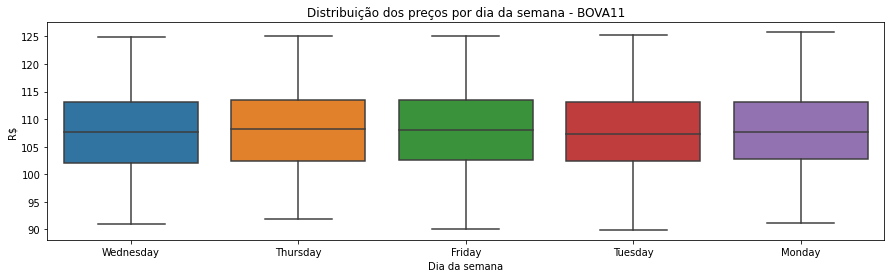

In [18]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(
    data=stock_mod_df,
    x='day_name',
    y="preco",
    ax=axs,
)
axs.set_title("Distribuição dos preços por dia da semana - BOVA11")
axs.set_ylabel("R$")
axs.set_xlabel("Dia da semana")
plt.show()

A distribução semanal dos preços é muito parecida. Dessa forma, não existe sazonalidade semanal nesta série (o que já exclui o dia da semana como feature do modelo.)

##### 4.1.2 Por dia do mês

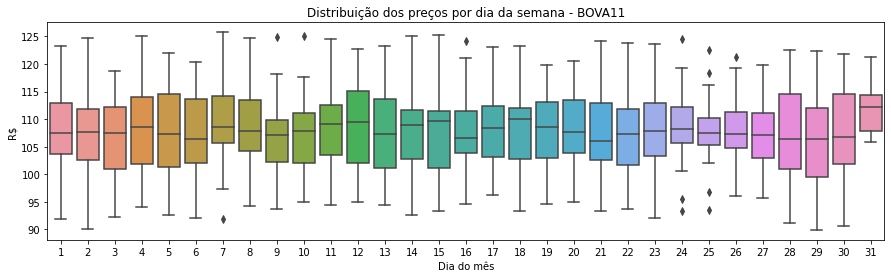

In [19]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(
    data=stock_mod_df,
    x='day_of_month',
    y="preco",
    ax=axs,
)
axs.set_title("Distribuição dos preços por dia da semana - BOVA11")
axs.set_ylabel("R$")
axs.set_xlabel("Dia do mês")
plt.show()


**Obs**
No período observado parece não haver sazonalidade dentro do mês, visto que as distribuições dos preços são bastante parecidas na maioria dos dias, variando um pouco na media.

Alguns dias possuiem a distribuição mais estreita, como os dias 24, 25 e 31 além de possuirem outliers também.

Vamos adicionar o dia do mês como feature no modelo.

##### 4.1.3 Por quarter

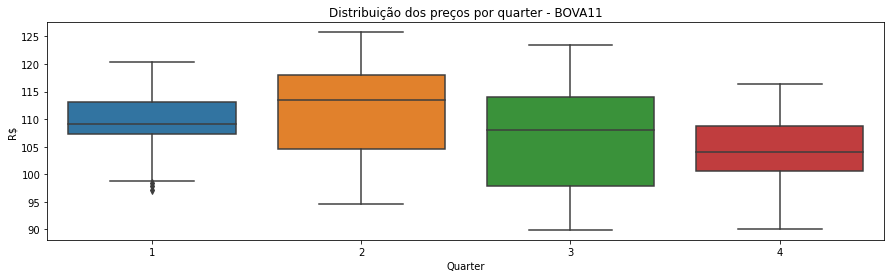

In [20]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(
    data=stock_mod_df,
    x='quarter',
    y="preco",
    ax=axs,
)
axs.set_title("Distribuição dos preços por quarter - BOVA11")
axs.set_ylabel("R$")
axs.set_xlabel("Quarter")
plt.show()


**Obs**
É possível ver uma leve diferença na distribuição dos dados de acordo com os quarters, apesar de que há bastante sobreposição nos valores, é possível ver uma boa diferença entre os quarters 1 e 4.

Vale a pena incluir essa feature no modelo.

##### 4.1.3 Por mês

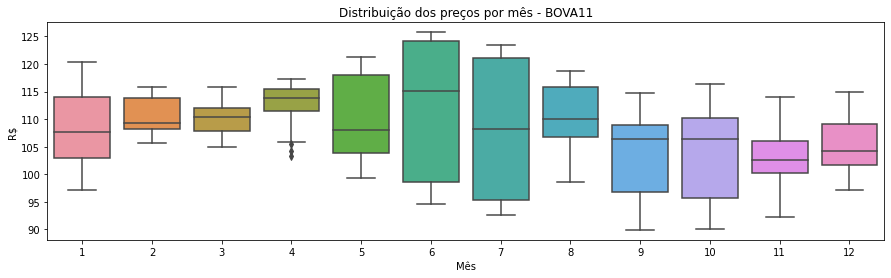

In [21]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(
    data=stock_mod_df,
    x='month',
    y="preco",
    ax=axs,
)
axs.set_title("Distribuição dos preços por mês - BOVA11")
axs.set_ylabel("R$")
axs.set_xlabel("Mês")
plt.show()

**Obs**

*[Considerando o período de 2020/09 - hoje]* O dia do mês parece fornecer uma boa separabilidade das distribuições. Os primeiros 3 meses do ano possuem uma média e mediana maior, enquanto o meio do ano é caracterizado por uma distribuição muito abrangente, e o ultimos 4 meses possuem valores menores.

Podemos dizer que existe uma leve sazonalidade anual na série.
Vamos incluir essa feature no modelo.


#### 4.2 Seasonal Decompose

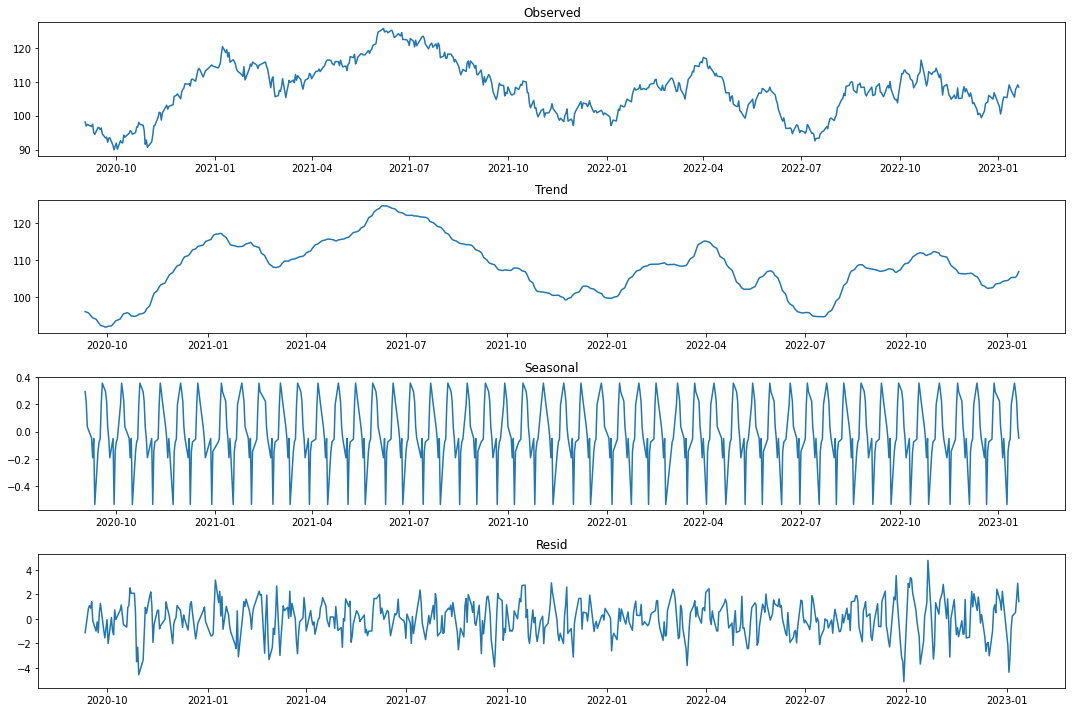

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))
decomposition = seasonal_decompose(stock_mod_df.set_index("data")['preco'], period=12)
  
axs[0].plot(decomposition.observed)
axs[1].plot(decomposition.trend)
axs[2].plot(decomposition.seasonal)
axs[3].plot(decomposition.resid)
  
axs[0].set_title("Observed")
axs[1].set_title("Trend")
axs[2].set_title("Seasonal")
axs[3].set_title("Resid")
plt.tight_layout()
plt.show()

### 5.0 Análise de autocorrelação

/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


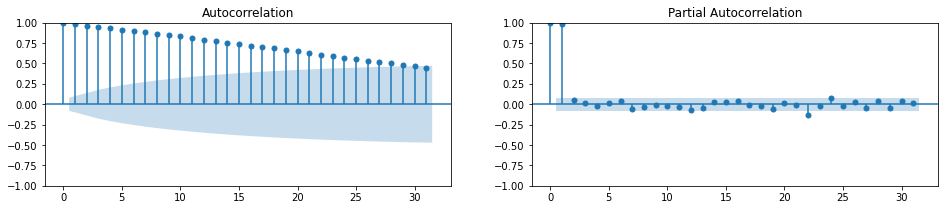

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (16,3))
plot_acf(stock_mod_df[["preco"]], lags=31, ax=ax1)
plot_pacf(stock_mod_df[["preco"]], lags=31, ax=ax2)
plt.show()

**Obs**

A série demonstra alta correlação parcial com o lag 1. Isso nos diz que a série possui boa previsibilidade (?) e possui sazonalidade fraca, visto que nenhum outro lag se mostrou relevante.

#### 5.1 Estacionariedade

In [32]:
adf_test = adfuller(stock_mod_df["preco"])
dfoutput=pd.Series(adf_test[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
print(dfoutput)
print('-'*50)

Test Statistic                  -2.477901
p-value                          0.120944
#lags used                       0.000000
number of observations used    591.000000
dtype: float64
--------------------------------------------------


In [34]:
adf_test = adfuller(stock_mod_df["preco"].diff().dropna())
dfoutput=pd.Series(adf_test[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
print(dfoutput)
print('-'*50)

Test Statistic                 -25.918458
p-value                          0.000000
#lags used                       0.000000
number of observations used    590.000000
dtype: float64
--------------------------------------------------


**Obs**

Com p-valor acima de 0.05, a série original é não estacionária. A mesma se torna estacionária com 1 diferenciação.